In [2]:
import torch 
import matplotlib.pyplot as plt 
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import to_undirected, add_remaining_self_loops
WEIGHTS = '../saved_weights/n2v_c-c.pt'

tr_g, (te_g, y) = torch.load('../saved_graphs/lanl_static_split_c-c.pt')
n2v = Node2Vec(tr_g, 128, 2,2)
n2v.load_state_dict(torch.load(WEIGHTS))
n2v.eval() 

ei = to_undirected(tr_g)
ei = add_remaining_self_loops(ei)[0]

with torch.no_grad():
    embs = n2v(torch.arange(ei.max()+1))

embs.size()

torch.Size([15610, 128])

In [3]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

def embed(ei):
    src,dst = ei 
    return embs[src] * embs[dst]

_,neg = n2v.sample(torch.arange(ei.max()+1))
neg = embed(neg[:, :2].T)
pos = embed(tr_g)

x = torch.cat([neg,pos])
y_ = torch.zeros(x.size(0))
y_[:neg.size(0)] = 1 

lr = LogisticRegression()
lr.fit(x,y_)

LogisticRegression()

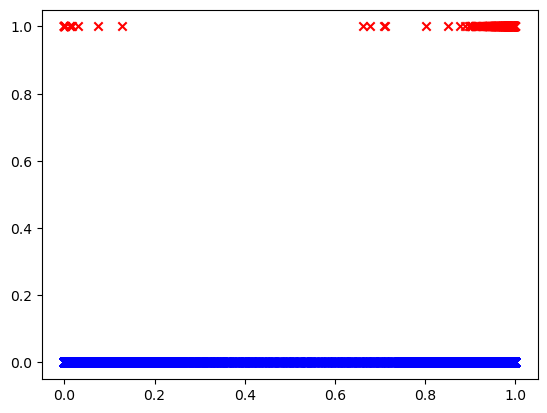

In [4]:
probs = lr.predict_proba(embed(te_g))[:, 1]
probs.shape[0]
plt.scatter(probs[y==1], torch.ones(probs[y==1].shape[0]), c='red', marker='x')
plt.scatter(probs[y==0], torch.zeros(probs[y==0].shape[0]), c='blue', marker='x')


In [11]:
y_hat = probs > 0.95
y_hat.sum()
fps = (y_hat * (y.numpy() == 0)).sum()
fpr = fps / (y==0).sum()

tpr = (y_hat * (y.numpy() == 1)).sum() / y.sum()

print(f'TPR: {tpr}, FPR: {fpr}')

TPR: 0.804635763168335, FPR: 0.0614599734544754
